# IWORMS Project

This file is part of iworms-synthetic : a python code for creating synthetic Green Function timeseries at each pair of station, applying timeshift for pairs related to first station, measuring this timeshift, and invert it.

Copyright (C) 2019 Albanne Lecointre, Philippe Roux, Christophe Picard, Pierre-Antoine Bouttier, Violaine Louvet             
Contact albanne.lecointre@univ-grenoble-alpes.fr

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the GNU General Public License for more details https://www.gnu.org/licenses/

The data have to be located in inputdata directory at the same level. The output file will be created in the same directory as the current script.

In [1]:
%matplotlib notebook
import h5py
import numpy as np
import sys
import math
from scipy.signal import butter, lfilter, gausspulse
import matplotlib.pyplot as plt
import argparse

In [2]:
class Args:
    v=1
    snr=5.0 # 0.8
    dec=0
    fi="./inputdata/dist_SW_synthetiques_3pairs.dat"

In [3]:
def set_parameters():
    """
        Set differents global variables
        :return sf:
        :return lnplot:
        :return vel:
        :return SW:
        :return nstep:
        :return decalage:
        :return nT1:
        :return LIN:
    """
    sf = 10  # sampling frequency
    lnplot = 1
    vel = 3.0  # km/s
    SW = 2
    # [0/1/2]
    # 0 : entire correlation time -300sec:300sec
    # 1 : zoom on surface wave but window width varies with the distance
    # 2 : zoom with constant window width = 40sec
    nstep = 480
    decalage = 1
    nT1 = 240
    # 240 : GFtimeref sur T1 (periode sans décalage)
    # 480 : GFtimeref sur T1+T2
    LIN = 0
    # 0 : decalage creneau 1sec sur T2
    # 1 : decalage lineaire 0 à 1sec along T2
    return sf,lnplot,vel,SW,nstep,decalage,nT1,LIN

In [4]:
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)

In [5]:
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }
    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)
    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)
    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)
    return c1, c2, bbox_patch1, bbox_patch2, p

In [6]:
def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}
    prop_lines = {**kwargs, "linestyle": "--"}
    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=prop_lines, prop_patches=prop_patches)
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)
    return c1, c2, bbox_patch1, bbox_patch2, p

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """
        :param lowcut:
        :param highcut:
        :param fs:
        :param order:
        :return:
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [8]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
def read_list_pairs(path):
    """
        read the list of synthetic pairs:
         - distance in meters
        :param path: file path
        :return: list
    """
    f = open(path, 'r')
    lines = f.readlines()
    f.close()
    dist = []
    for l in lines:
        splitline = l.split(' ')
        dist.append(splitline[0])
    return dist

In [10]:
def compute_Dt(deltat, nstep, nbsta, nbref):
    """ 
        Dt computation:
        Dt(S=j,ref=k) = (1/nbsta) * ( sum( deltat[j,:]) ) - sum ( deltat[k,:] ) )
        :param deltat:
        :param nstep:
        :param nbsta:
        :param nbref:
    """
    Dt = np.zeros((nbref, nstep, nbsta), dtype=np.float32)
    invN = 1.0/float(nbsta)
    dt_2D = np.zeros((nbsta, nbsta), dtype=np.float32)
    sumdt = np.empty((nbsta,), dtype=np.float32)
    for istep in np.arange(nstep):
        # reorganize flattened allpairs vector dt into an antisymmetric matrix
        # diag(dt_2D) should be 0-init
        cpt = 0
        for ji in np.arange(nbsta-1):
            for jj in np.arange(ji+1, nbsta):
                dt_2D[ji, jj] = deltat[istep, cpt]
                dt_2D[jj, ji] = -deltat[istep, cpt]
                cpt += 1
        for ji in np.arange(nbsta):
            # On calcule la somme des (N-1) elements non nuls de chaque ligne
            # (dt(ji,1)+dt(ji,2)+...+dt(ji,N))
            sumdt[ji] = np.sum(dt_2D[ji, :])
        # On choisit la station k comme référence, on suppose donc Dt(k)=0
        # On itère pour toutes les k références
        for iref in np.arange(nbref):
            for ji in np.arange(nbsta):
                # On calcule les differences de sommes 2 a 2
                Dt[iref, istep, ji] = invN*(sumdt[ji]-sumdt[iref])
    return Dt

In [11]:
def compute_Dtw(deltat, coh, nstep, nbsta, nbref):
    """ Calcul du Dtw:
     Dtw(S=j,ref=k) = sum( deltat[j,:]*coh[j,:] ) / sum( coh[j,:] without coh[j,j] )
                    - sum( deltat[k,:]*coh[k,:] ) / sum( coh[k,:] without coh[k,k] )
    """
    Dtw = np.zeros((nbref, nstep, nbsta), dtype=np.float32)
    dt_2D = np.zeros((nbsta, nbsta), dtype=np.float32)
    co_2D = np.zeros((nbsta, nbsta), dtype=np.float32)
    # on met zero sur la diag des coh !
    # en effet les éléments diagonaux sont inconnus
    # une autre option serait de considérer diag(dt)=0 et diag(coh)=1
    # mais on ne fait pas ca: pour nous ce sont des inconnues et elles n'entrent pas dans le calcul
    # c'est pour cela que Dtw .NEQ. Dt même si toutes les coh=1
    sumdtcoh = np.empty((nbsta,), dtype=np.float32)
    sumcoh = np.empty((nbsta,), dtype=np.float32)
    for istep in np.arange(nstep):
        # reorganize flattened allpairs vector dt into an antisymmetric matrix
        # diag(dt_2D) should be 0-init
        cpt = 0
        for ji in np.arange(nbsta-1):
            for jj in np.arange(ji+1, nbsta):
                dt_2D[ji, jj] = deltat[istep, cpt]
                dt_2D[jj, ji] = -deltat[istep, cpt]
                co_2D[ji, jj] = coh[istep, cpt]
                co_2D[jj, ji] = coh[istep, cpt]
                cpt += 1
        for ji in np.arange(nbsta):
            # On calcule la somme des (N-1) elements non nuls de chaque ligne
            # (dt(ji,1)+dt(ji,2)+...+dt(ji,N))
            sumdtcoh[ji] = np.dot(dt_2D[ji, :],co_2D[ji,:])
            sumcoh[ji] = np.sum(co_2D[ji,:])
        # On choisit la station k comme référence, on suppose donc Dt(k)=0
        # On itère pour toutes les k références
        for iref in np.arange(nbref):
            for ji in np.arange(nbsta):
                # On calcule les differences de sommes 2 a 2
                Dtw[iref, istep, ji] = (sumdtcoh[ji]/sumcoh[ji])-(sumdtcoh[iref]/sumcoh[iref])
    return Dtw

In [12]:
def compute_coherence(refGF_norm, stepGF, dt, sf):
    """ 
        Consistency measurement between refGF_norm and stepGF, associated with the shift dt
        :param refGF_norm:
        :param stepGF:
        :param dt: shift
        :param sf:
    """
    idec = int(round(-sf*dt))
    stepGF_rolled = np.roll(stepGF, idec)
    stepGF_rolled_norm = stepGF_rolled / max(abs(stepGF_rolled))
    coherence = np.corrcoef(refGF_norm, stepGF_rolled_norm)[1, 0]
    return coherence

In [13]:
def write_f32gz(fid, var, varname):
    """ 
        Create and write a dataset named varname, containing variable var, into HDF5 file identifier fid, 
        with F32 encoding, and apply gz compression filter
        :param fid: HDF5 file identifier
        :param var: variable to write (array of float 32)
        :param varname: name of the dataset
    """
    dset = fid.create_dataset(varname,
                              data=var,
                              dtype="float32",
                              compression="gzip")
    return dset

In [14]:
def options():
    """
        Get the options for the current execution
        Help message
    """
    parser = argparse.ArgumentParser(
            description="measure dt and compute Dt on synthetic data")
    parser.add_argument("-v",
                        type=int,
                        default=1,
                        help="set logging level: 0 none, 1 info (default=1)")
    parser.add_argument("--snr",
                        default=100.0,
                        type=float,
                        help="SNR (default=100.0)")
    parser.add_argument("--dec",
                        default=0,
                        type=int,
                        help="set option to apply a decreasing factor of GF \
                              amplitude for distance > 20km \
                              (default=0 : disable)")
    parser.add_argument(
        "--fi",
        default='./inputdata/dist_SW_synthetiques_3081pairs.dat',
        type=str,
        help="input file containing list of pairs and distance \
        (default=./inputdata/dist_SW_synthetiques_3081pairs.dat)"
    )

    args = parser.parse_args()
    return args

In [15]:
def central_freq():
    """
    Define a central frequency for phase
    """
    fb1 = 0.1
    fb2 = 0.2   # frequence choisie   % 5-10sec = 0.1-0.2Hz
    X = 0.5*(fb1+fb2)
    omega = 2.0 * math.pi * X
    inv_omega = 1.0 / omega
    return X,omega,inv_omega

In [16]:
def get_gauspuls():
    # Get gauspuls from provided input file
    f = h5py.File('./inputdata/gauspuls.h5', 'r')
    sbc = f['signal_base_centre'][()]
    f.close()
    return sbc

In [17]:
def compute_gauspuls(time0,X):
    # default fr bw in gausspulse is 0.5
    sbc = gausspulse(time0,X)
    return sbc

In [18]:
def shift(ip,nbsta,LIN,istep,GF,sf,nT2):
    """
    On impose un décalage de la première station, sur la période T2
    """
    # on ne décale que les N-1 premières paires
    # (les paires de la premiere station)
    if ip < nbsta-1:
        # decalage lineaire sur T2
        if LIN == 1:
            istepdec += 1
            decsec = (1.0 / nT2 ) * istepdec
            tmp = GF[istep, :]
            GF[istep, :] = np.roll(tmp, int(round(decsec*sf)))
        else:  # creneau sur T2
            decsec = 1
            tmp = GF[istep, :]
            GF[istep, :] = np.roll(tmp, int(round(decsec*sf)))

In [19]:
def measure_dt(omega,time0,bsw,esw,GF,nT1,nstep,ip,inv_omega,deltat,coh,sf):
    """
    """
    # try to measure dt for each step

    phase = np.exp(1j * omega * time0[bsw:esw])
    # compute the reference
    rGF = np.mean(GF[0:int(nT1), bsw:esw], axis=0)
    # and normalized ref (for coherence)
    rGF_n = rGF/max(abs(rGF))
    # DFT signal ref
    rDFT = np.dot(rGF, phase)
    for istep in np.arange(nstep):
        # DFT signal perturbé (step)
        sDFT = np.dot(GF[istep, bsw:esw], phase)
        # mesure du dt
        deltat[istep, ip] = np.angle(sDFT/rDFT) * inv_omega
        coh[istep, ip] = compute_coherence(rGF_n,
                                           GF[istep, bsw:esw],
                                           deltat[istep, ip],
                                           sf)

In [20]:
def main():
    #args = options()
    args=Args()
    ln_verbose = args.v
    SNR = args.snr
    decGF = args.dec
    # 0 : no GF amplitude decrease with distance
    # 1 : after 20km, decrease GF amplitude with factor 1/sqrt(dist/20km)
    fileinput = args.fi

    sf,lnplot,vel,SW,nstep,decalage,nT1,LIN = set_parameters()
    
    nT2 = nstep-nT1 # number of timesteps in T2 period
    
    # time vector in sec (only positive part: GF would be symmetric)
    time0 = np.arange(-300.0, 300.0+1.0/float(sf), 1.0/float(sf))

    # Get some metrics : pair distances, start and end indexes
    # for surface wave zoom (in case of SW=1)
    dist = read_list_pairs(fileinput)
    nbpair = len(dist)
    nbsta = int(math.ceil(math.sqrt(2.0*nbpair)))

    # Define a central frequency for phase
    fc,omega,inv_omega = central_freq()

    # Gauspuls
    #sbc = get_gauspuls()
    sbc = compute_gauspuls(time0,fc)
    
    # Filter feature 
    lowcut = 0.1
    highcut = 0.2
    bb, aa = butter_bandpass(lowcut, highcut, sf, order=3)

    # Array initialisation (adjacent memory for pairs)
    deltat = np.zeros((nstep, nbpair), dtype=np.float32)
    coh = np.zeros((nstep, nbpair), dtype=np.float32)

    if ln_verbose:
        print("measure dt for all pairs")
        print("ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))")

    for ip in np.arange(nbpair):
        
        if lnplot:
            plt.figure()
            plt.clf()
        
        # keep GF in memory for each timesteps
        GF = np.zeros((nstep, len(time0)), dtype=np.float32)

        # indexes for possible zoom on surface wave
        distance = float(dist[ip])*1e-3  # km
        if SW == 1:
            sys.exit("Option SW=1 does not work")
        elif SW == 2:
            # window with fixed width 40 s, centered on gauspuls center for positive times
            # Only if to closed to zero, shift to right
            t1 = max(distance/vel-20.0, 0)  
            t2 = t1+40.0
            bsw = 3000+round(sf*t1)
            esw = 3001+round(sf*t2)
        else:
            bsw = 0
            esw = len(time0)

        rGF = np.zeros((esw-bsw,), dtype=np.float32)
        phase = np.zeros((esw-bsw,), dtype=np.complex64)

        # gauspuls : positive side + negative side
        decalage0 = int(round(sf*(distance/vel)))
        signal_base = np.roll(sbc, decalage0) + np.roll(sbc, -decalage0)

        # Apply decreasing factor GF amplitude for distances > 20km
        if (int(decGF) == 1) and (distance > 20.0):
            decfactor = 1.0/np.sqrt(distance/20.0)
            signal_base *= decfactor

        if lnplot:
            # plot base (T1)
            ax1 = plt.subplot(2, 1, 1)
            ax1.plot(time0, signal_base, 'b', label=r'$CC_{ref}^{p='+str(ip)+'}$')
            ax1.plot([time0[bsw], time0[bsw]], [-1, 1], '--r')
            ax1.plot([time0[esw], time0[esw]], [-1, 1], '--r')
            ax1.grid()
            ax1.set_xlim((-300, 300))
            ax1.set_ylim((-1, 1))
            ax1.set_xticks([-300, 0, 300])
            ax1.set_title('dist = {:6.2f} km, SNR = {:3.1f}'.format(distance,SNR))

        # timestep loop : add noise and shift in time
        istepdec = 0
        for istep in np.arange(nstep):

            # creates rand matrix and add it to the GF foreach time steps
            r = np.random.uniform(-1, 1, len(time0))
            r = lfilter(bb, aa, r)
            r /= max(abs(r))  # normalize
            r /= float(SNR)  # fix SNR
            GF[istep, :] = signal_base + r
            
            if lnplot and (istep == 0):
                ax1.plot(time0, r, 'grey', label='noise')
                ax1.legend(loc='right')

                ax2 = plt.subplot(2, 1, 2)
                ax2.plot(time0, signal_base, 'b', label=r'$CC_{ref}^{p='+str(ip)+'}$')
                ax2.plot(time0, GF[istep], 'k', label=r'$CC_{i \in T1}^{p='+str(ip)+'}$')
                ax2.grid()
                ax2.set_xlim((time0[bsw], time0[esw]))
                ax2.set_ylim((-1.5, 1.5))

            if decalage == 1 and istep >= nT1:
                shift(ip,nbsta,LIN,istep,GF,sf,nT2)

        # end loop on timesteps for adding noise and shift

        # Now we cut all nstep GF for this pair between swb and swe
        # and we measure dt for each step
        measure_dt(omega,time0,bsw,esw,GF,nT1,nstep,ip,inv_omega,deltat,coh,sf)

        if ln_verbose:
            if lnplot:
                print("ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))")
            print(ip,
                  np.mean(deltat[0:nT1, ip]),
                  np.var(deltat[0:nT1, ip]),
                  np.mean(deltat[nT1:nstep, ip]),
                  np.var(deltat[nT1:nstep, ip]))

        if lnplot:
            ax2.plot(time0[bsw:esw], GF[nT1, bsw:esw], 'r', label=r'$CC_{i \in T2}^{p='+str(ip)+'}$')
            ax2.legend(loc='right')
            ax2.set_xlabel(r'$t (s)$')
            ax2.text(time0[bsw]+5, -1.3, r'$\delta^{p='+str(ip)+'}_{i \in T2}\
                      ='+'{:4.2f}'.format(deltat[nT1, ip])+', \
                      coh^{p='+str(ip)+'}_{i \in T2}\
                      ='+'{:4.2f}'.format(coh[nT1, ip])+'$', color='r')
            zoom_effect01(ax1, ax2, time0[bsw], time0[esw])
            plt.savefig('pair'+str(ip)+'_decGF'+str(decGF)+'_SNR'+str(SNR)+'.png', dpi=600)
            plt.show()
    # end of global loop over all the pairs

    # write dt into h5 output file
    outfile = "SNR{0}_SW{1}_decGF{2}_REF{3}_LIN{4}_nstep{5}_nbpair{6}" \
              ".h5".format(SNR, SW, decGF, nT1, LIN, nstep, nbpair)
    f = h5py.File(outfile, 'w')
    dset = write_f32gz(f, deltat, "dt")
    dset = write_f32gz(f, coh, "coh")

    # Calcul du Dt
    # Dt(S=j,ref=k) = (1/N) * ( sum( dt[j,:]) ) - sum ( dt[k,:] ) )

    nbref = nbsta  # on essaiera toutes les sta comme ref, successivement
    Dt = compute_Dt(deltat, nstep, nbsta, nbref)

    dset = write_f32gz(f, Dt, "Dt")

    # On moyenne les solutions obtenues avec toutes les références
    # N.B. : cela revient au même que de directement moyenner
    # tous les dts arrivant (ou partant selon convention choisie) à un noeud
    Dt_mean_ref = np.mean(Dt, axis=0)

    dset = write_f32gz(f, Dt_mean_ref, "Dt_mean_ref")
    
    # Calcul du Dtw
    # Dtw(S=j,ref=k) = sum( dt[j,:]*coh[j,:] ) / sum( coh[j,:] without coh[j,j] ) 
    #                - sum( dt[k,:]*coh[k,:] ) / sum( coh[k,:] without coh[k,k] )

    Dtw = compute_Dtw(deltat, coh, nstep, nbsta, nbref)

    dset = write_f32gz(f, Dtw, "Dtw")

    f.close()

    if ln_verbose:
        print("compute Dt for all stations")
        ista = 0
        iref = 1
        print("Dt of first station if second station is the reference, "
              "mean(T1), var(T1), mean(T2), var(T2)")
        print(np.mean(Dt[iref, 0:nT1, ista]),
              np.var(Dt[iref, 0:nT1, ista]),
              np.mean(Dt[iref, nT1:nstep, ista]),
              np.var(Dt[iref, nT1:nstep, ista]))
        print("Dt of first station if all stations (including first) "
              "are successively the references, mean(T1), var(T1), "
              "mean(T2), var(T2)")
        print(np.mean(Dt_mean_ref[0:nT1, ista]),
              np.var(Dt_mean_ref[0:nT1, ista]),
              np.mean(Dt_mean_ref[nT1:nstep, ista]),
              np.var(Dt_mean_ref[nT1:nstep, ista]))
        print("Dtw of first station if second station is the reference, "
              "mean(T1), var(T1), mean(T2), var(T2)")
        print(np.mean(Dtw[iref, 0:nT1, ista]),
              np.var(Dtw[iref, 0:nT1, ista]),
              np.mean(Dtw[iref, nT1:nstep, ista]),
              np.var(Dtw[iref, nT1:nstep, ista]))

measure dt for all pairs
ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))


<IPython.core.display.Javascript object>


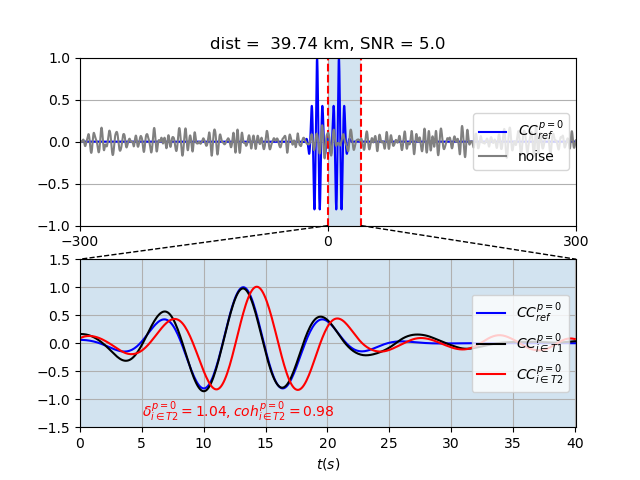

ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))
0 8.3522005e-05 0.011420968 0.987948 0.008758063


<IPython.core.display.Javascript object>


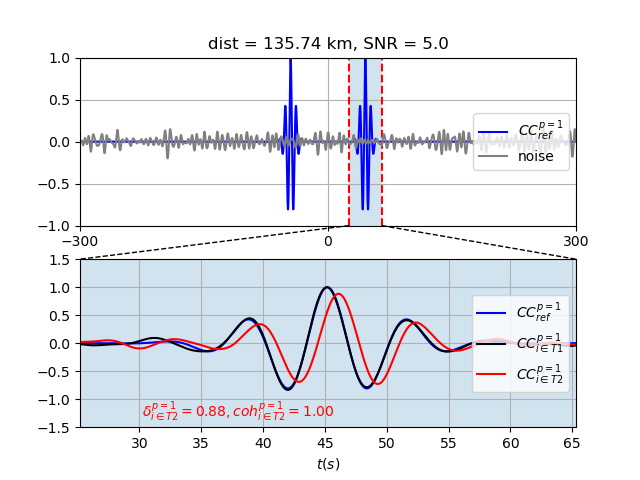

ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))
1 0.000114811955 0.010646003 0.9909545 0.009728923


<IPython.core.display.Javascript object>


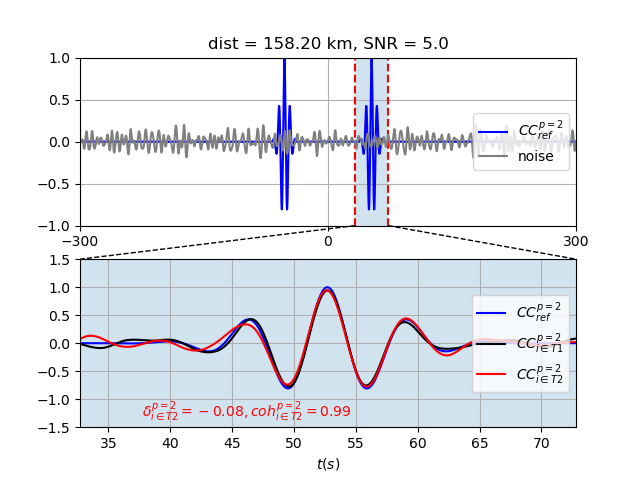

ip, mean(dt(T1)), var(dt(T1)), mean(dt(T2)), var(dt(T2))
2 -0.00071465375 0.008495196 -0.0063113067 0.0098070325
compute Dt for all stations
Dt of first station if second station is the reference, mean(T1), var(T1), mean(T2), var(T2)
0.00033217022 0.007424516 0.9910539 0.0067570517
Dt of first station if all stations (including first) are successively the references, mean(T1), var(T1), mean(T2), var(T2)
6.611173e-05 0.002537884 0.6596342 0.0020488785
Dtw of first station if second station is the reference, mean(T1), var(T1), mean(T2), var(T2)
0.0003801624 0.01661143 1.4862164 0.015135148


In [21]:
main()